# Visualisation Sketch Book


### Loading the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
from ExtraFunctions import DataFrameSelector, CategoricalEncoder
data = pd.read_csv("data/airbnb/listings-2017.csv")
num_features = ['amenities', 'bedrooms', 'number_of_reviews', 'review_scores_rating', 'accommodates', 'cleaning_fee', 'guests_included', 'beds', 'guests_included', 'bathrooms', 'price']
cat_features = [ 'neighbourhood_cleansed', 'room_type', 'bed_type', 'property_type']

# Where to save the figures
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
print("These are all our features: ", data.columns.values)

These are all our features:  ['id' 'listing_url' 'scrape_id' 'last_scraped' 'name' 'summary' 'space'
 'description' 'experiences_offered' 'neighborhood_overview' 'notes'
 'transit' 'access' 'interaction' 'house_rules' 'thumbnail_url'
 'medium_url' 'picture_url' 'xl_picture_url' 'host_id' 'host_url'
 'host_name' 'host_since' 'host_location' 'host_about' 'host_response_time'
 'host_response_rate' 'host_acceptance_rate' 'host_is_superhost'
 'host_thumbnail_url' 'host_picture_url' 'host_neighbourhood'
 'host_listings_count' 'host_total_listings_count' 'host_verifications'
 'host_has_profile_pic' 'host_identity_verified' 'street' 'neighbourhood'
 'neighbourhood_cleansed' 'neighbourhood_group_cleansed' 'city' 'state'
 'zipcode' 'market' 'smart_location' 'country_code' 'country' 'latitude'
 'longitude' 'is_location_exact' 'property_type' 'room_type' 'accommodates'
 'bathrooms' 'bedrooms' 'beds' 'bed_type' 'amenities' 'square_feet' 'price'
 'weekly_price' 'monthly_price' 'security_deposit' 'cl

### Clean and prepare features

In [3]:
df = data[num_features].copy()
df.fillna('0', inplace=True)
df['quality'] = (df.amenities.str.count(',') + 1).astype(float) * (df['number_of_reviews']).astype(float) *  (df['review_scores_rating']).astype(float)
df['price'] = df['price'].str.replace(r'[$,]', '').astype(float)
df['cleaning_fee'] = df['cleaning_fee'].str.replace(r'[$,]', '').astype(float)
price = df['price']

num_features.remove('amenities')
num_features.remove('price')

### Data Pipeline

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Imputer, PolynomialFeatures

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_features)),
    ('imputer', Imputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

X = num_pipeline.fit_transform(df)

### Run t-SNE

In [7]:
%%time
# This takes a few minutes to plot on the full set, you may run it on a smallet set for faster result

df_plus = data[cat_features].copy()
y = np.arange(len(df_plus['neighbourhood_cleansed'].value_counts()))
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X) # X[:1000] run it on the first 1,000 samples for faster results

Wall time: 9min 49s


### Plot t-SNE

In [9]:
# Let's create segment the price into some bins
minimum, maximum = df['price'].min(), df['price'].max()

bins = np.linspace(minimum, maximum, 5)
labels = np.arange(0, 4, 1)
price_labels = ['Very Cheap', 'Cheap', 'Average', 'Expensive', 'Very Expensive']

binned = pd.qcut(df['price'], len(price_labels)-1)

price_cat = pd.qcut(df['price'], len(price_labels)-1, labels=labels)

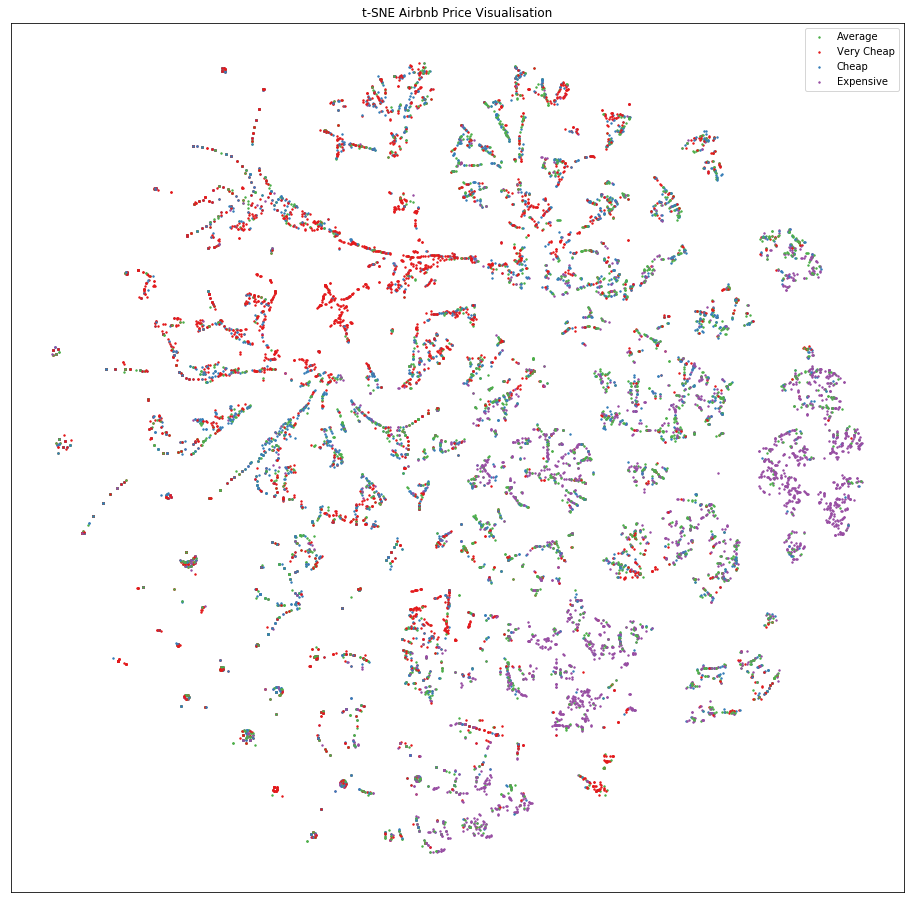

In [11]:
from collections import OrderedDict

plt.figure(figsize=(16,16))
ax = plt.subplot(111)

for i in range(X_tsne.shape[0]):
    ax.scatter(X_tsne[i, 0], X_tsne[i, 1], s=2, color=plt.cm.Set1(price_cat[i]), label=price_labels[price_cat[i]])

plt.xticks([]), plt.yticks([])
plt.title('t-SNE Airbnb Price Visualisation')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

#save_fig('t-SNE')

### Plot scatter matrix

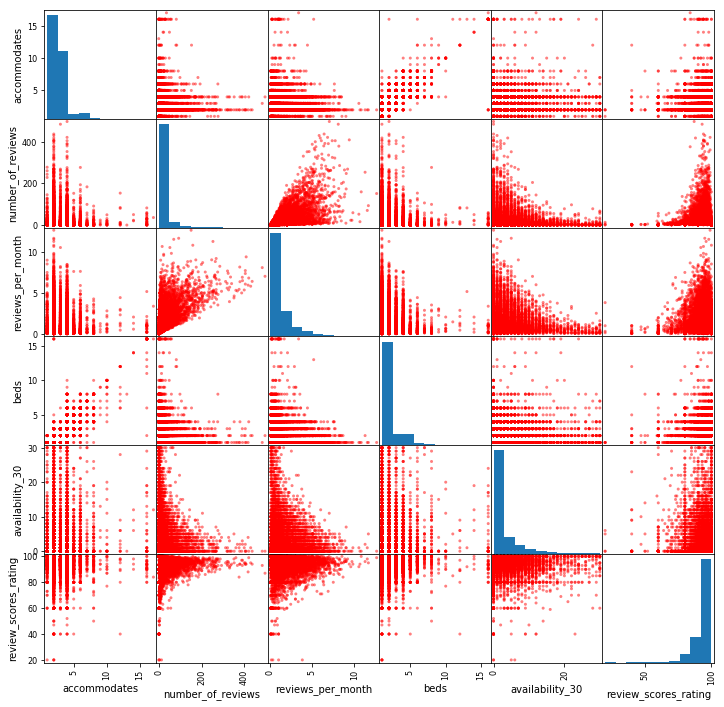

In [13]:
scattercols = ['price', 'accommodates', 'number_of_reviews', 'reviews_per_month', 'beds', 'availability_30', 'review_scores_rating']
pd.plotting.scatter_matrix(data[scattercols], figsize=(12, 12), c='red');

### Group and prepare data for pie chart

In [28]:
df2 = data[['price','neighbourhood_cleansed','number_of_reviews']].copy()

df2['price'] = df2['price'].replace('[\$,)]','',regex=True).replace('[(]','-', regex=True).astype(float)

df2 = df2[df2.price != 0]
df2 = df2.dropna(axis=0)


grouped = df2.groupby(df2.neighbourhood_cleansed).mean()

#grouped = grouped.sort_values(['number_of_reviews'])

sums = grouped.sum()

num = len(grouped.index)

theta = np.linspace(0.0, 2 * np.pi, num, endpoint=False)
radii = grouped.number_of_reviews.values[:num] / grouped.number_of_reviews.values[:num].max()
width = (grouped.price.values[:num] / grouped.price.values[:num].max())*0.4

### Plot chart

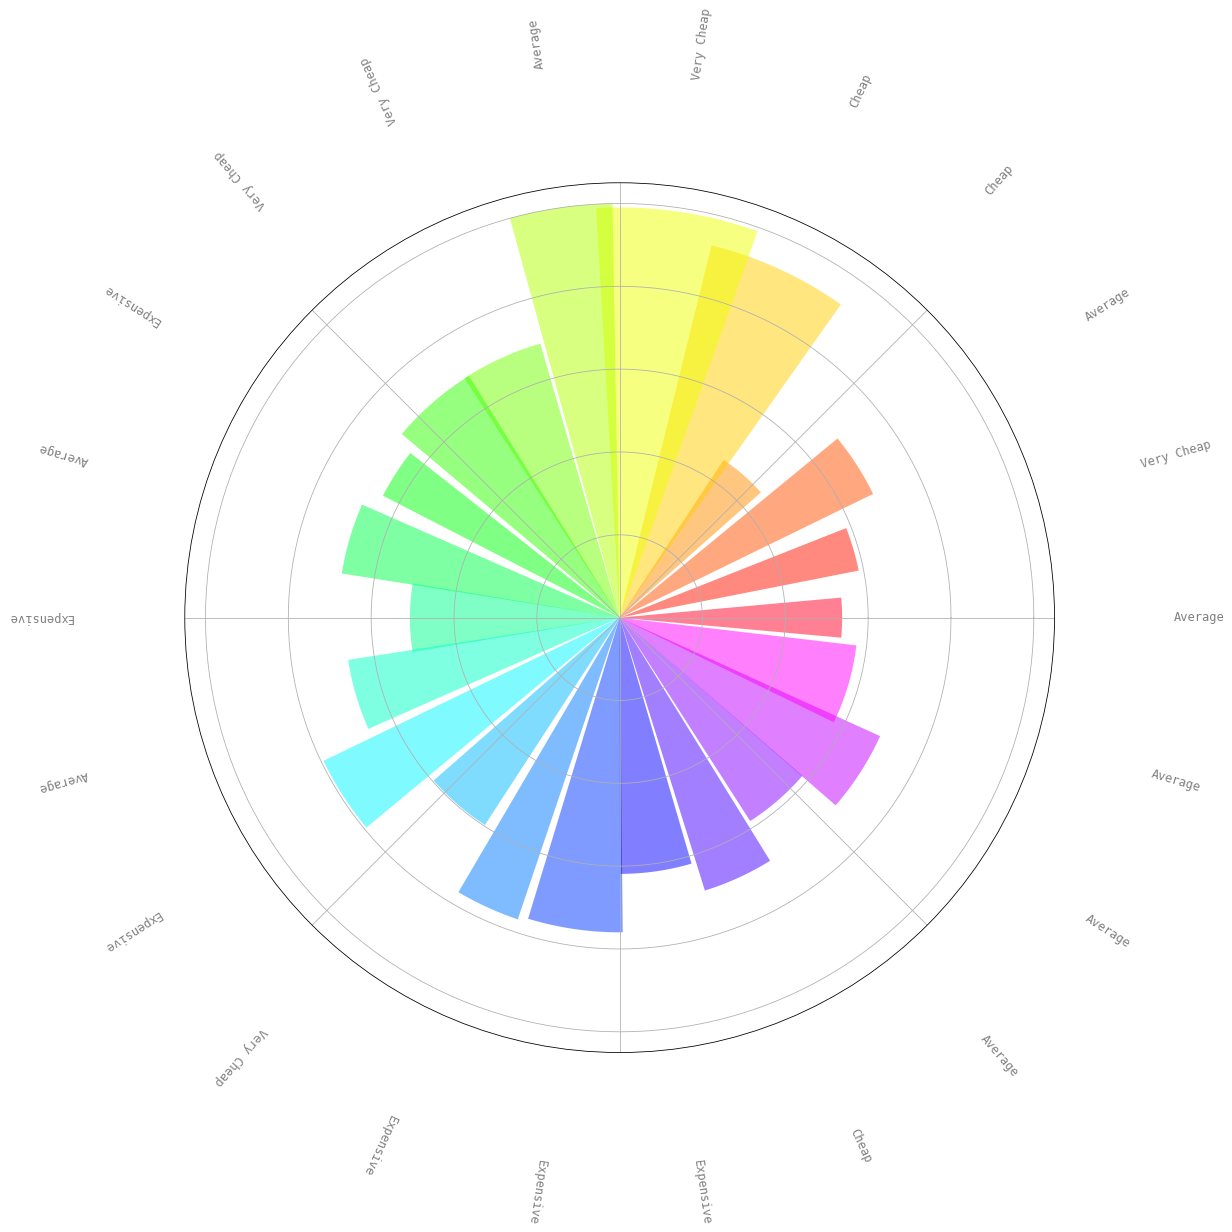

In [30]:
fig = plt.figure(figsize=(16, 16))
ax = plt.subplot(111, projection='polar')
bars = ax.bar(theta, radii, width=width)
count = 0
cm = plt.get_cmap('gist_rainbow')

ax.set_xticklabels([])
ax.set_yticklabels([])


# Use custom colors and opacity
for r, bar in zip(radii, bars):
    bar.set_facecolor(cm(count/num))
    bar.set_alpha(0.5)
    bar.set_label(grouped.index.values[count])
    ax.text(theta[count], radii.max()*1.4, labels[count], 
            horizontalalignment='center', verticalalignment='center', 
            rotation=(count)*360/num, color='0.5', family='monospace', fontsize='large')
    count += 1

plt.autoscale()
#save_fig('polar_chart',)